## Toy Sampling Animations 5 - Sample Quality Sanity Check

In [12]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from smalldiffusion import (
    TimeInputMLP, ScheduleLogLinear, training_loop, samples,
    DatasaurusDozen, Swissroll, ModelMixin
)
from torch.utils.data import Dataset
from tqdm import tqdm
from torch import nn
from pathlib import Path
# import cv2
from PIL import Image

from typing import Optional, Union, Tuple
from itertools import pairwise

def plot_batch(batch):
    batch = batch.cpu().numpy()
    plt.scatter(batch[:,0], batch[:,1], marker='.')
    plt.axis('equal')

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [14]:
# save_dir=Path('/home/stephen/sora/jun_16_3')
# save_dir.mkdir(exist_ok=True)

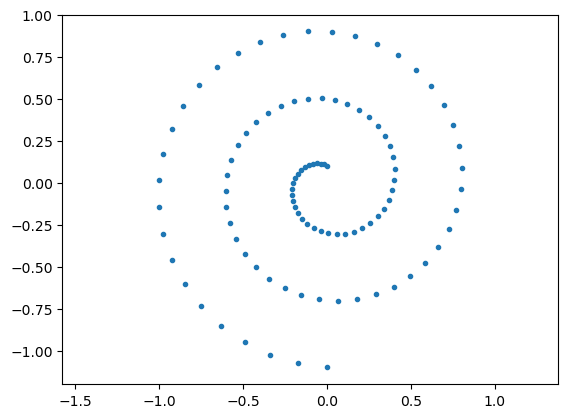

In [15]:
batch_size=2130
dataset = Swissroll(np.pi/2, 5*np.pi, 100)
loader = DataLoader(dataset, batch_size=batch_size)
plot_batch(next(iter(loader)))

In [16]:
schedule = ScheduleLogLinear(N=64, sigma_min=0.01, sigma_max=10) #N=200
# plt.plot(schedule.sigmas)

In [17]:
device='cpu' #Faster for toy model?
epochs=15000 #15000
lr=1e-3 #1e-3
model = TimeInputMLP(hidden_dims=(16,128,128,128,128,16))
# model = MLP(hidden_dims=(16,128,128,128,128,16)) #no time conditioning
model.to(device);
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
loss_func=nn.MSELoss()

losses=[]
for _ in tqdm(range(epochs)):
    for x0 in loader:
        model.train()
        optimizer.zero_grad()
        
        eps = torch.randn_like(x0)
        sigma = schedule.sample_batch(x0)

        noised_data=x0 + sigma.unsqueeze(-1) * eps
        yhat=model(noised_data.to(device), sigma.to(device), cond=False) #lose usqueeze here for images?
        loss=loss_func(eps.to(device), yhat)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()

100%|████████████████████████████████████████| 15000/15000 [00:47<00:00, 315.20it/s]


In [41]:
torch.save(model, '/home/stephen/sora/jun_24_1.pt')

In [19]:
bound=1.5
num_heatmap_steps=30
grid=[]
for i, x in enumerate(np.linspace(-bound, bound, num_heatmap_steps)):
    for j, y in enumerate(np.linspace(-bound, bound, num_heatmap_steps)):
        grid.append([x,y])
grid=torch.tensor(grid).float()

In [36]:
model.to(device);
gam=1
mu=0.5 #0.5 is DDPM
cfg_scale=0.0
cond=None
sigmas=schedule.sample_sigmas(64)
xt_history=[]
heatmaps=[]

with torch.no_grad():
    model.eval();
    xt=torch.randn((batch_size,) + model.input_dims)*sigmas[0] #Scaling by sigma here matters a lot - why is that???

    for i, (sig, sig_prev) in enumerate(pairwise(sigmas)):
        eps_prev, eps = eps, model.predict_eps_cfg(xt, sig.to(xt), cond, cfg_scale)
        # eps_av = eps * gam + eps_prev * (1-gam)  if i > 0 else eps
        sig_p = (sig_prev/sig**mu)**(1/(1-mu)) # sig_prev == sig**mu sig_p**(1-mu)
        eta = (sig_prev**2 - sig_p**2).sqrt()
        xt = xt - (sig - sig_p) * eps + eta * model.rand_input(xt.shape[0]).to(xt)
        xt_history.append(xt.numpy())
        heatmaps.append(model.forward(grid, sig, cond=None))

xt_history=np.array(xt_history)

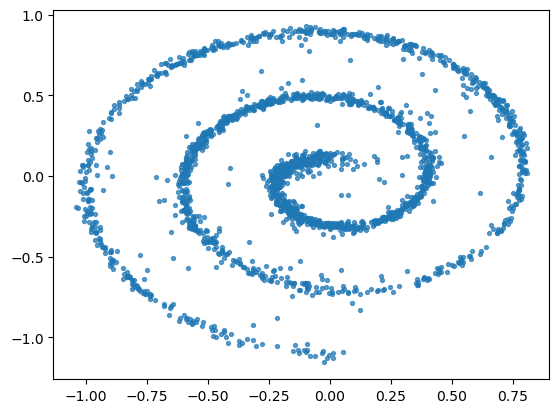

In [40]:
plt.scatter(xt_history[-1][:,0], xt_history[-1][:,1], alpha=0.7, s=8)

In [35]:
xt_history[10]

array([[nan, nan],
       [nan, nan],
       [nan, nan],
       ...,
       [nan, nan],
       [nan, nan],
       [nan, nan]], dtype=float32)

In [29]:
xt_history.shape

(256, 2130, 2)

---

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from smalldiffusion import (
    TimeInputMLP, ScheduleLogLinear, training_loop, samples,
    DatasaurusDozen, Swissroll
)

def plot_batch(batch):
    batch = batch.cpu().numpy()
    plt.scatter(batch[:,0], batch[:,1], marker='.')

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

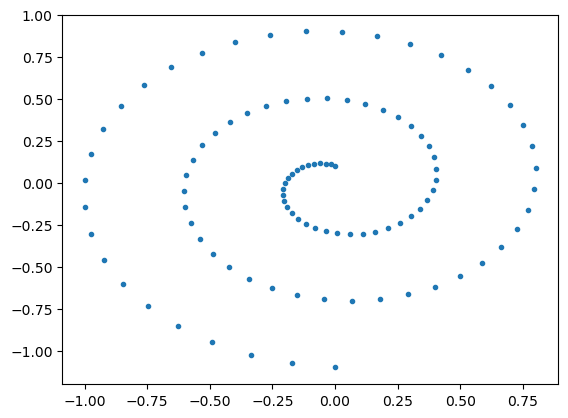

In [3]:
# Try replacing dataset with 'dino', 'bullseye', 'h_lines', 'x_shape', etc. 
# dataset = DatasaurusDozen(csv_file='../datasets/DatasaurusDozen.tsv', dataset='dino')
# Or use the SwissRoll dataset
dataset = Swissroll(np.pi/2, 5*np.pi, 100)
loader = DataLoader(dataset, batch_size=2130)
plot_batch(next(iter(loader)))

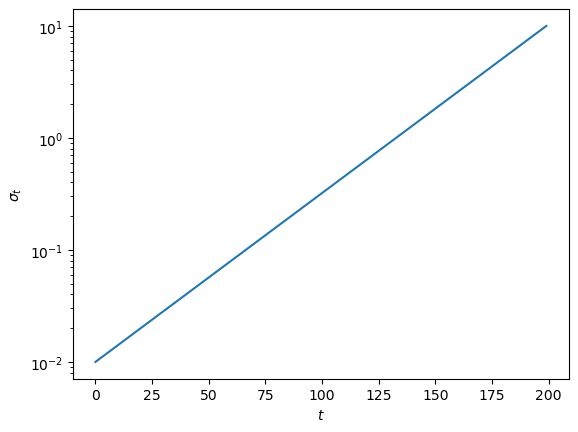

In [4]:
schedule = ScheduleLogLinear(N=200, sigma_min=0.01, sigma_max=10)
plt.plot(schedule.sigmas)
plt.xlabel('$t$')
plt.ylabel('$\sigma_t$')
plt.yscale('log')

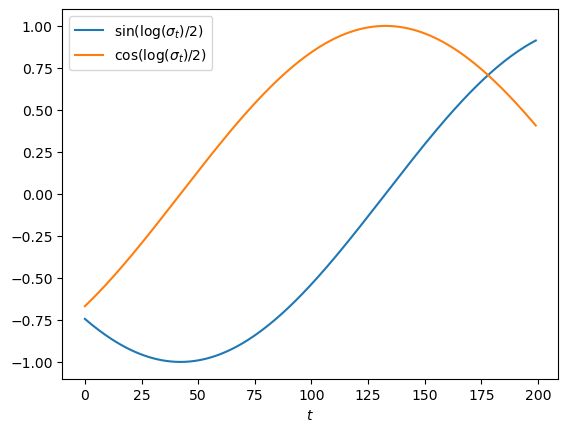

In [5]:
from smalldiffusion.model import get_sigma_embeds
sx, sy = get_sigma_embeds(len(schedule), schedule.sigmas).T
plt.plot(sx, label='$\sin(\log(\sigma_t)/2)$')
plt.plot(sy, label='$\cos(\log(\sigma_t)/2)$')
plt.xlabel('$t$')
plt.legend()
plt.show()

In [6]:
model = TimeInputMLP(hidden_dims=(16,128,128,128,128,16))
print(model)

TimeInputMLP(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=16, out_features=128, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): GELU(approximate='none')
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): GELU(approximate='none')
    (10): Linear(in_features=128, out_features=16, bias=True)
    (11): GELU(approximate='none')
    (12): Linear(in_features=16, out_features=2, bias=True)
  )
)


In [7]:
trainer = training_loop(loader, model, schedule, epochs=15000, lr=1e-3)
losses = [ns.loss.item() for ns in trainer]

100%|████████████████████████████████████████| 15000/15000 [02:16<00:00, 110.22it/s]


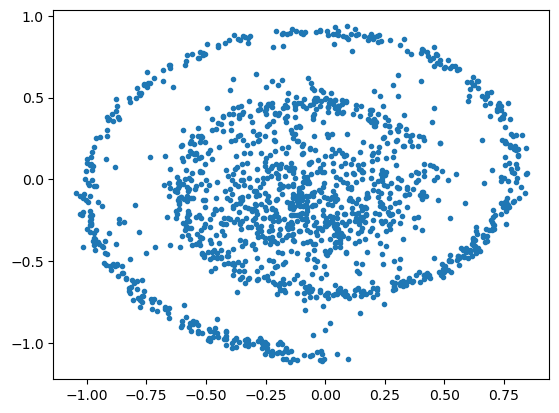

In [11]:
# For DDPM sampling, change to gam=1, mu=0.5
# For DDIM sampling, change to gam=1, mu=0
*xts, x0 = samples(model, schedule.sample_sigmas(64), batchsize=1500, gam=1, mu=0.5)
plot_batch(x0)